In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
import pickle
import baltic as bt
import json

In [10]:
tree_file = '../titer_model/substitution_model_output/dengue_all_tree.json'
performance_file = '../titer_model/substitution_model_output/titer_model_performance.csv'
substitutions_file = '../titer_model/substitution_model_output/dengue_allsubstitution_model.json'

In [8]:
colors = pickle.load(open('./colors.p', 'rb'))

In [33]:
performance = pd.read_csv(performance_file, index_col=None)
performance = performance.melt(value_vars=['rms_error', 'r_squared'], var_name='metric')
tree = bt.loadJSON(tree_file, {'name': 'strain', 'height': 'div'})
substitutions = json.load(open(substitutions_file, 'r'))


Tree height: 0.352840
Tree length: 2.074358
annotations present

Numbers of objects in tree: 92 (45 nodes and 47 leaves)



In [42]:
def get_dTiter(branch, muts = substitutions['mutations']):    
    if 'aa_muts' not in branch.traits:
        branch.traits['dTiter'] = None
        branch.traits['n_antigenic_muts'] = None
        return
    
    dTiter = 0.
    n_antigenic_muts = 0
    for m in branch.traits['aa_muts']['E']:
        if 'E:'+m in muts:
            dTiter += muts['E:'+m]
            n_antigenic_muts += 1
            
    branch.traits['dTiter'] = dTiter
    branch.traits['n_antigenic_muts'] = n_antigenic_muts

for k in tree.nodes:
    get_dTiter(k)

In [58]:
def plot_tree(ll, ax, cmap = plt.cm.viridis):
    sns.set(style='white',font_scale=1.2)

    max_dTiter = max([k.traits['dTiter'] for k in tree.nodes if 'dTiter' in k.traits and k.traits['dTiter'] is not None])
    for k in ll.Objects: ## iterate over objects in tree
        x=k.x ## or from x position determined earlier
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        if 'dTiter' in k.traits and k.traits['dTiter'] > 0.05:
            c = cmap(k.traits['dTiter'] / max_dTiter)
            branchWidth = 2
            ax.text((x+xp)/2,y,'x '*k.traits['n_antigenic_muts'], ha='center', va='center', fontsize=10, zorder=1000)
        else:
            c = 'gray'
            branchWidth = 1

        if isinstance(k,bt.node) or k.branchType=='node': ## if node...
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)

        ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        
    ax.set_yticks([])
    ax.set_xticks([round(x, 2) for x in np.linspace(0, ll.treeHeight, 5)])
    ax.set_ylim(-5,ll.ySpan+7)
    ax.set_xlabel('Substitutions per site')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    
def plot_performance(performance, ax):
    sns.set(style='whitegrid',font_scale=1.2)
    
    sns.boxplot(x='metric', y='value', data=performance, notch=True)
#     sns.swarmplot(x='metric', y='value', hue='model', data=performance, hue_order=['interserotype', 'full tree'], 
#                   palette=[colors['interserotype_effects'], colors['all_effects']], dodge=True, alpha=0.8)
    ax.set_xlabel('')
    ax.set_ylabel('')

              value
metric             
r_squared  0.821560
rms_error  0.712139


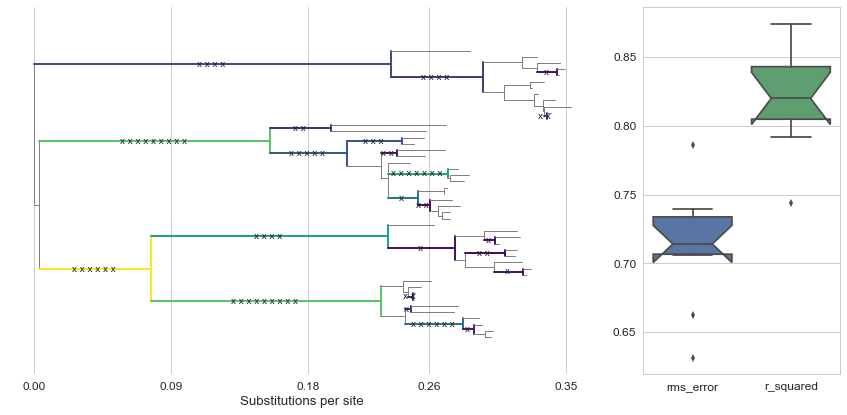

In [59]:
fig, (tree_ax, performance_ax) = plt.subplots(1,2,figsize=(12,6), gridspec_kw={'width_ratios': [3,1]})
sns.set(font_scale=1.3, style='whitegrid')

plot_tree(tree, ax=tree_ax)
plot_performance(performance, ax=performance_ax)


plt.tight_layout()
# plt.savefig('./png/titer_model_performance.png', dpi=300, bbox_inches='tight')
avg_performance = performance.groupby(['metric']).agg('mean')
print avg_performance